# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Exploratory Data Analysis (EDA) of the Teranet dataset
---

This notebook describes _Step 3: Explore_  of OSEMN methodology performed on the Teranet dataset.

Previous steps included: 

**Step 2: Scrub:**

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

* **Step 2.3:** addition of new attributes to the Teranet dataset

* during Step 2.3, **two versions of the Teranet dataset were produced**:

    * one where `consideration_amt` was left unmodified
    
    * one where `consideration_amt` < 10'000 CAD was reset to NaN and these records were removed from the dataset (1,615,178 records (23.74% of the total) have been removed. 5,188,513 records remain in the Teranet dataset).

New attributes were added to both versions of the Teranet dataset:
 
* surrogate key:

    * `transaction_id`: unique identifier for each Teranet transaction 
    
Essentially, a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`
    
* attributes for display

    * `date_disp`: `registration_date` converted to `datetime.date` data type to exclude the timestamp (original `registration_date` is stored in NumPy's `datetime64` format to allow more efficient datetime operations)
    
    * `price_disp`: `consideration_amt` formatted to include thousands separator (_e.g.,_ '3,455,122') and stored as a string, for display purposes
    
* attributes for record grouping
    
    * `year`: year parsed from `registration_date`, to simplify record grouping
    
    * `3year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2014-2016'), to simplify record grouping
    
    * `5year`: `registration_date` parsed for 5-year intervals (_e.g.,_ '2012-2016'), to simplify record grouping
    
    * `10year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2007-2017'), to simplify record grouping
    
    * `xy`: `x` and `y` coordinates concatenated together (_e.g.,_ '43.098324_-79.234235'), can be used to identify and group records by their coordinate pairs
    
* correction of `consideration_amt` for inflation    
    
    * `price_infl`: `consideration_amt` corrected for inflation
    
* exploratory attributes

    * `pin/xy_total_sales`: total records for this `pin`/`xy`

    * `pin/xy_prev_sales`: previous records from this `pin`/`xy` (not counting current transaction)

    * `pin/xy_price_cum_sum`: cumulative price of all records to date from this `pin`/`xy`

    * `pin/xy_price_pct_change`: price percentage change compared to previous record from this `pin`/`xy`

    * `price_da_pct_change`: price percentage change compared to previous record from this DA (by `da_id`)

    * `pin/xy_years_since_last_sale`: years since last sale from this `pin`/`xy`

    * `da_days_since_last_sale`, `da_years_since_last_sale`: days or years since last sale from this DA (by `da_id`)

    * `sale_next_6m/1y/3y`: "looks into the future" to see whether there is another transaction from this `pin`/`xy` within the given time horizon (6 months, 1 year, 3 years)

    * for details, see `notebooks/2.scrub/2.3_teranet_new_cols.ipynb` and `notebooks/2.scrub/2.3_teranet_nonan_new_cols.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 3: Explore_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import os
from time import time

sns.set()

In [2]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['Teranet_consistent.csv',
 'Teranet_with_DA_cols.csv',
 'Teranet_new_cols.csv',
 'Teranet_nonan_new_cols.csv',
 'HHSaleHistory.csv']

## Load Teranet data

In [3]:
t = time()

df = pd.read_csv(data_path + 'Teranet_nonan_new_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 63.80 seconds (1.06 minutes)
with 5,188,513 rows
and 44 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'objectid', 'dauid', 'csdname',
       'street_name_raw', 'date_disp', 'price_disp', 'year', '3year', '5year',
       '10year', 'xy', 'pin_total_sales', 'xy_total_sales', 'pin_prev_sales',
       'xy_prev_sales', 'pin_price_cum_sum', 'xy_price_cum_sum',
       'pin_price_pct_change', 'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y'],
      dtype='object')


In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5188513 entries, 0 to 5188512
Data columns (total 44 columns):
transaction_id               5188513 non-null int64
lro_num                      5188513 non-null int64
pin                          5188513 non-null int64
consideration_amt            5188513 non-null float64
registration_date            5188513 non-null datetime64[ns]
postal_code                  4881914 non-null object
unitno                       1332614 non-null object
street_name                  5144061 non-null object
street_designation           5090453 non-null object
street_direction             550657 non-null object
municipality                 5187161 non-null object
street_number                5142790 non-null object
x                            5188513 non-null float64
y                            5188513 non-null float64
objectid                     5188513 non-null int64
dauid                        5188513 non-null int64
csdname                      51885

## Count of records by Land Registry Office

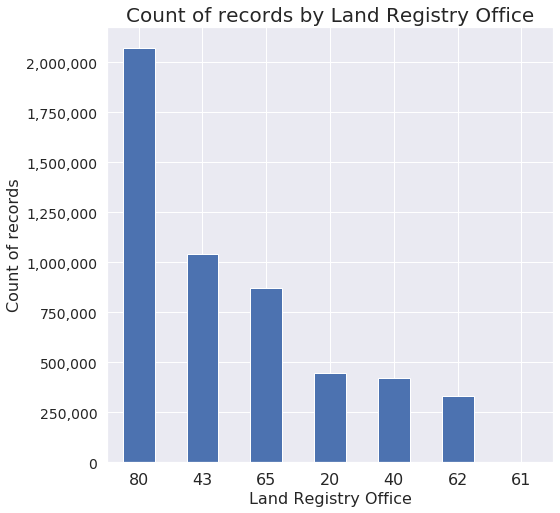

In [5]:
ax = df['lro_num'].value_counts().plot(kind='bar', figsize=(8, 8))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Land Registry Office", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Count of records by Land Registry Office", fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=14)
plt.show()

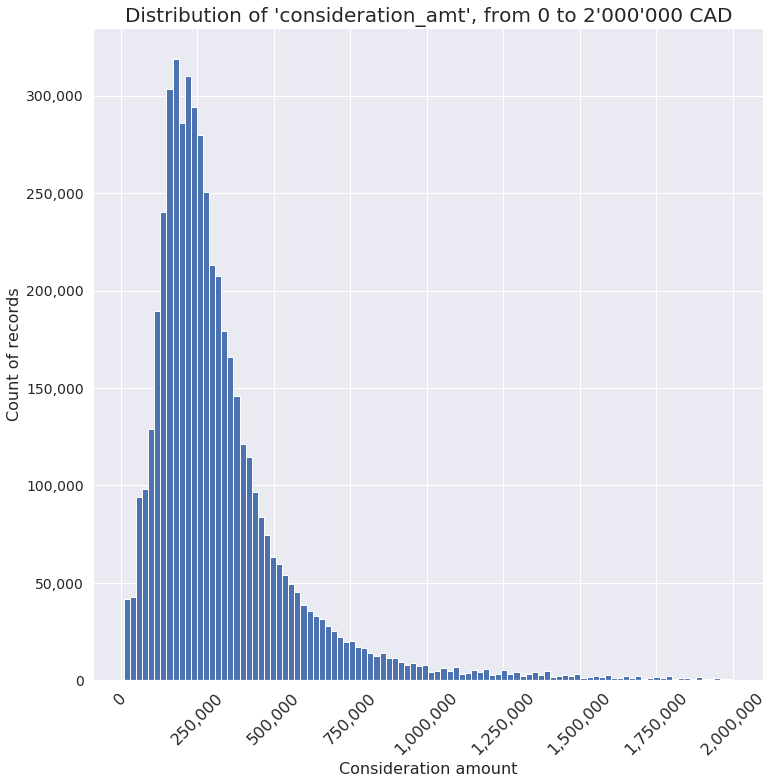

In [6]:
ax = df.query('consideration_amt < 2000000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 0 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/teranet_price_dist.png', dpi=300, bbox_inches='tight')

In [30]:
df['xy'].str.len().max()

37